In [1]:
from python_scripts.diversification import TriggerSimulation
from python_scripts.dynamic_asset_allocation import DAASimulation
from python_scripts.data_and_descriptives import *

from datetime import date
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

#### Import data

[*********************100%***********************]  4 of 4 completed


Ticker,AUSF,LVHI,MLPA,SQLV
Date,,,,
2019-01-02,18.216553,16.456741,25.910440,22.193651
2019-01-03,18.109489,16.528145,26.243479,22.257978
2019-01-04,18.480074,16.801519,27.608938,22.965605
2019-01-07,18.661257,16.789959,28.075199,23.340551
2019-01-08,18.834196,16.852520,28.907795,23.406719
...,...,...,...,...
2025-09-29,46.340000,34.700001,48.470001,42.680000
2025-09-30,46.509998,34.750000,48.419998,42.736000
2025-10-01,46.270000,34.930000,48.520000,42.796001


using CLOSING PRICES...


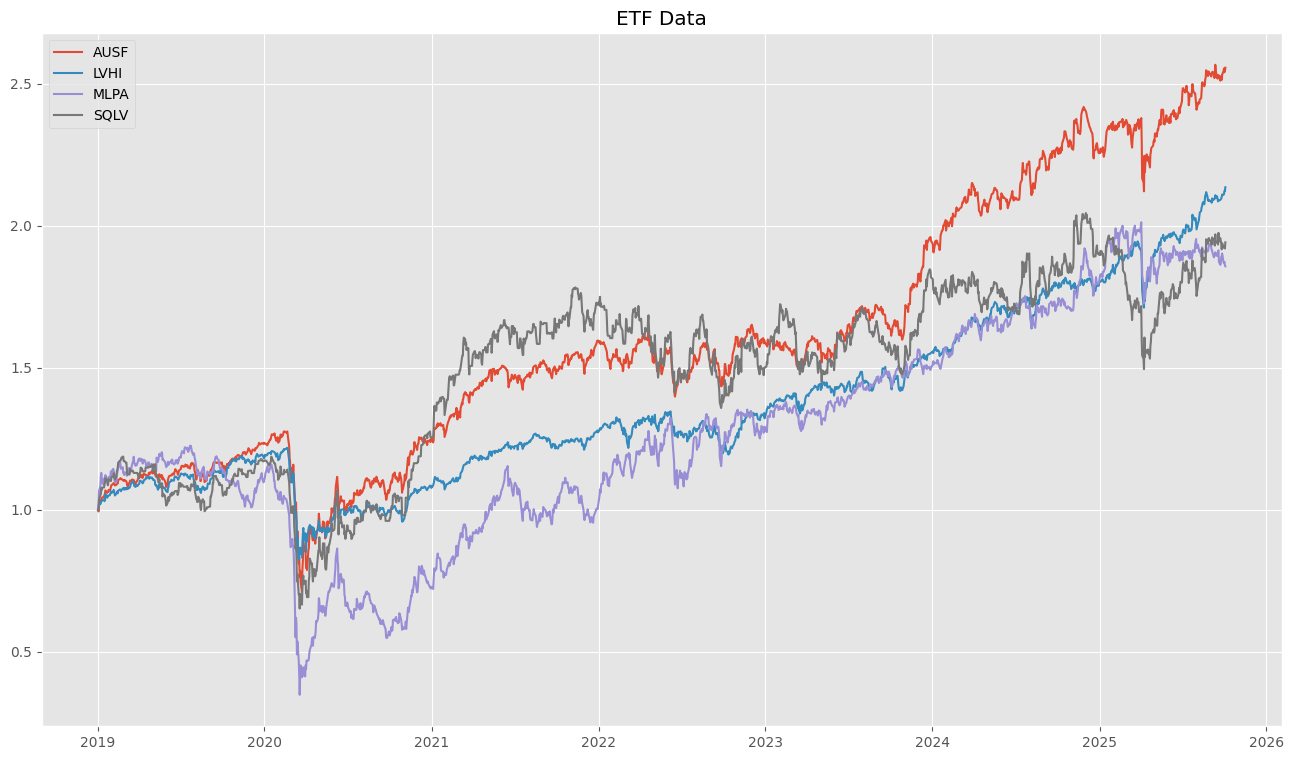

In [2]:
freq = "1d"
tickers = ['AUSF','LVHI', 'SQLV','MLPA']
start = '2019-01-01'
end = date.today()
prices = data_yahoo(tickers,freq, start, end, ['Adj Close'], False)
display(prices)
prices = fix_na_data_yahoo(prices)
prices = normalize_data(prices, False, 1, True, True)
returns = prices.pct_change().dropna()

### Backtest of diversification algorithm

##### Try rebalancing with stop loss and take profit

using gamma = 0.5
using weight bounds = (0, 0.4)
backtesting cap_floor strategy using thresholds (% return) of [0.1, 0.07]
using cash_bank as safe asset...


c:\Users\germa\Documents\Python\dynamic_asset_allocation\python_scripts\diversification.py:115: RuntimeWarning: invalid value encountered in divide
  return (da/da_rebal - 1 > self.threshold[0]) | (da/da_rebal - 1 < -self.threshold[1])


using RETURNS...
--- 1.1670658588409424 seconds ---


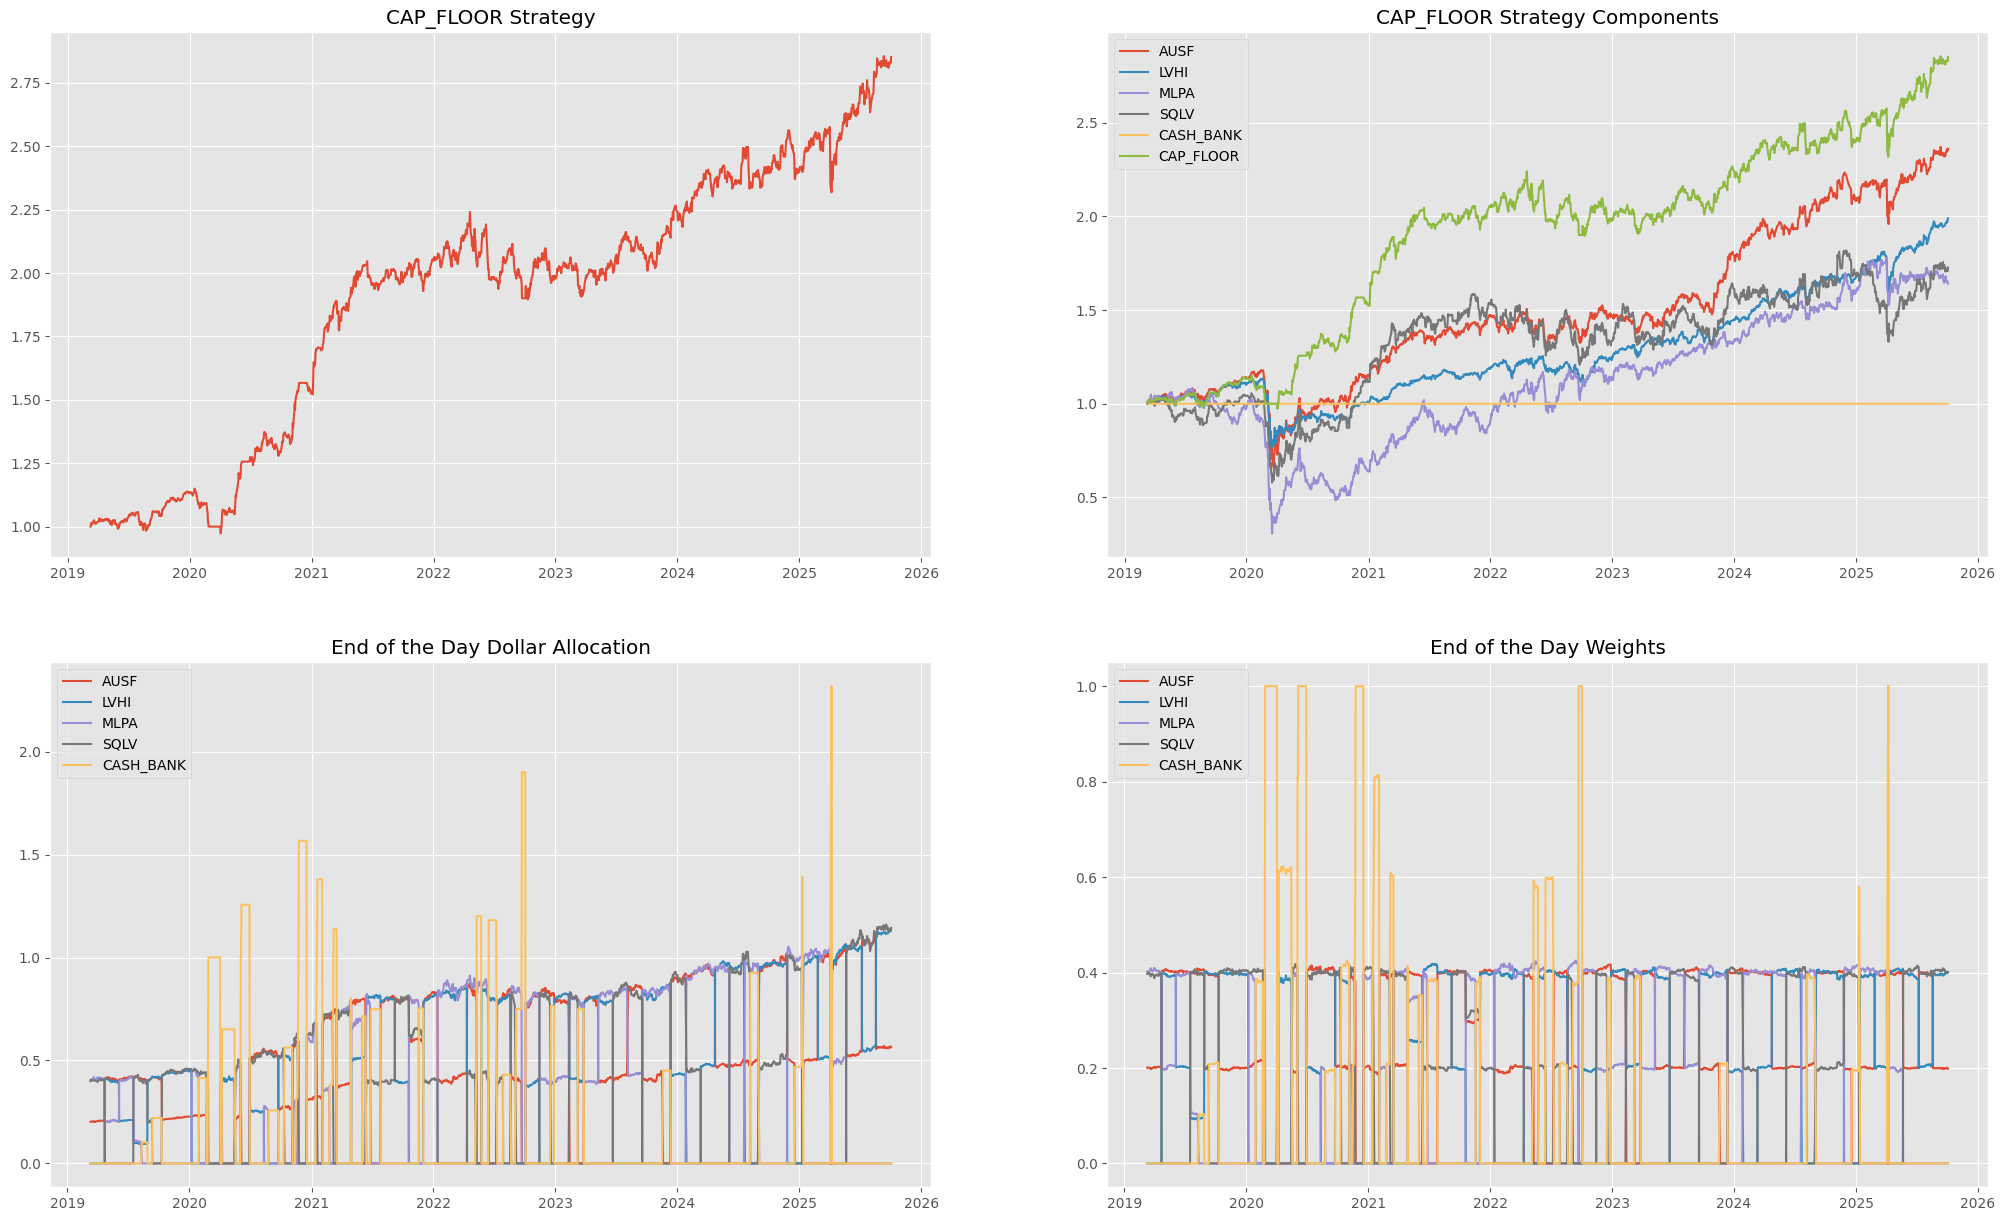

In [3]:
trigger_simulation = TriggerSimulation(returns, exit_type='cap_floor', rebal_type= 'markowitz', safe_asset='cash_bank',
                                       threshold=[0.1,0.07], window=45, rebal = 30, gamma = 0.5, w_bounds = (0,0.4))
backtest_results = trigger_simulation.trigger_simulation()

### Dynamic Asset Allocation

In [4]:
m=3.0
start_value=float(1)
kappa=0.8
window=0
rebal = 1
w_bounds=[0,1]
are_returns = True
plot = True

In [5]:
daa = pd.concat([pd.DataFrame(returns['AUSF']) , backtest_results['portfolio_value'].pct_change().dropna()], axis = 1).dropna() # drop first 30 days required for first HRP estimation


Summary: 
 strategy: Relative Maximum Drawdown 
 m = 3.0 
 kappa: 0.8 
             rebalancing frequency: 1 
 weight bounds: [0, 1]
using RETURNS...
--- 3.272796630859375 seconds ---


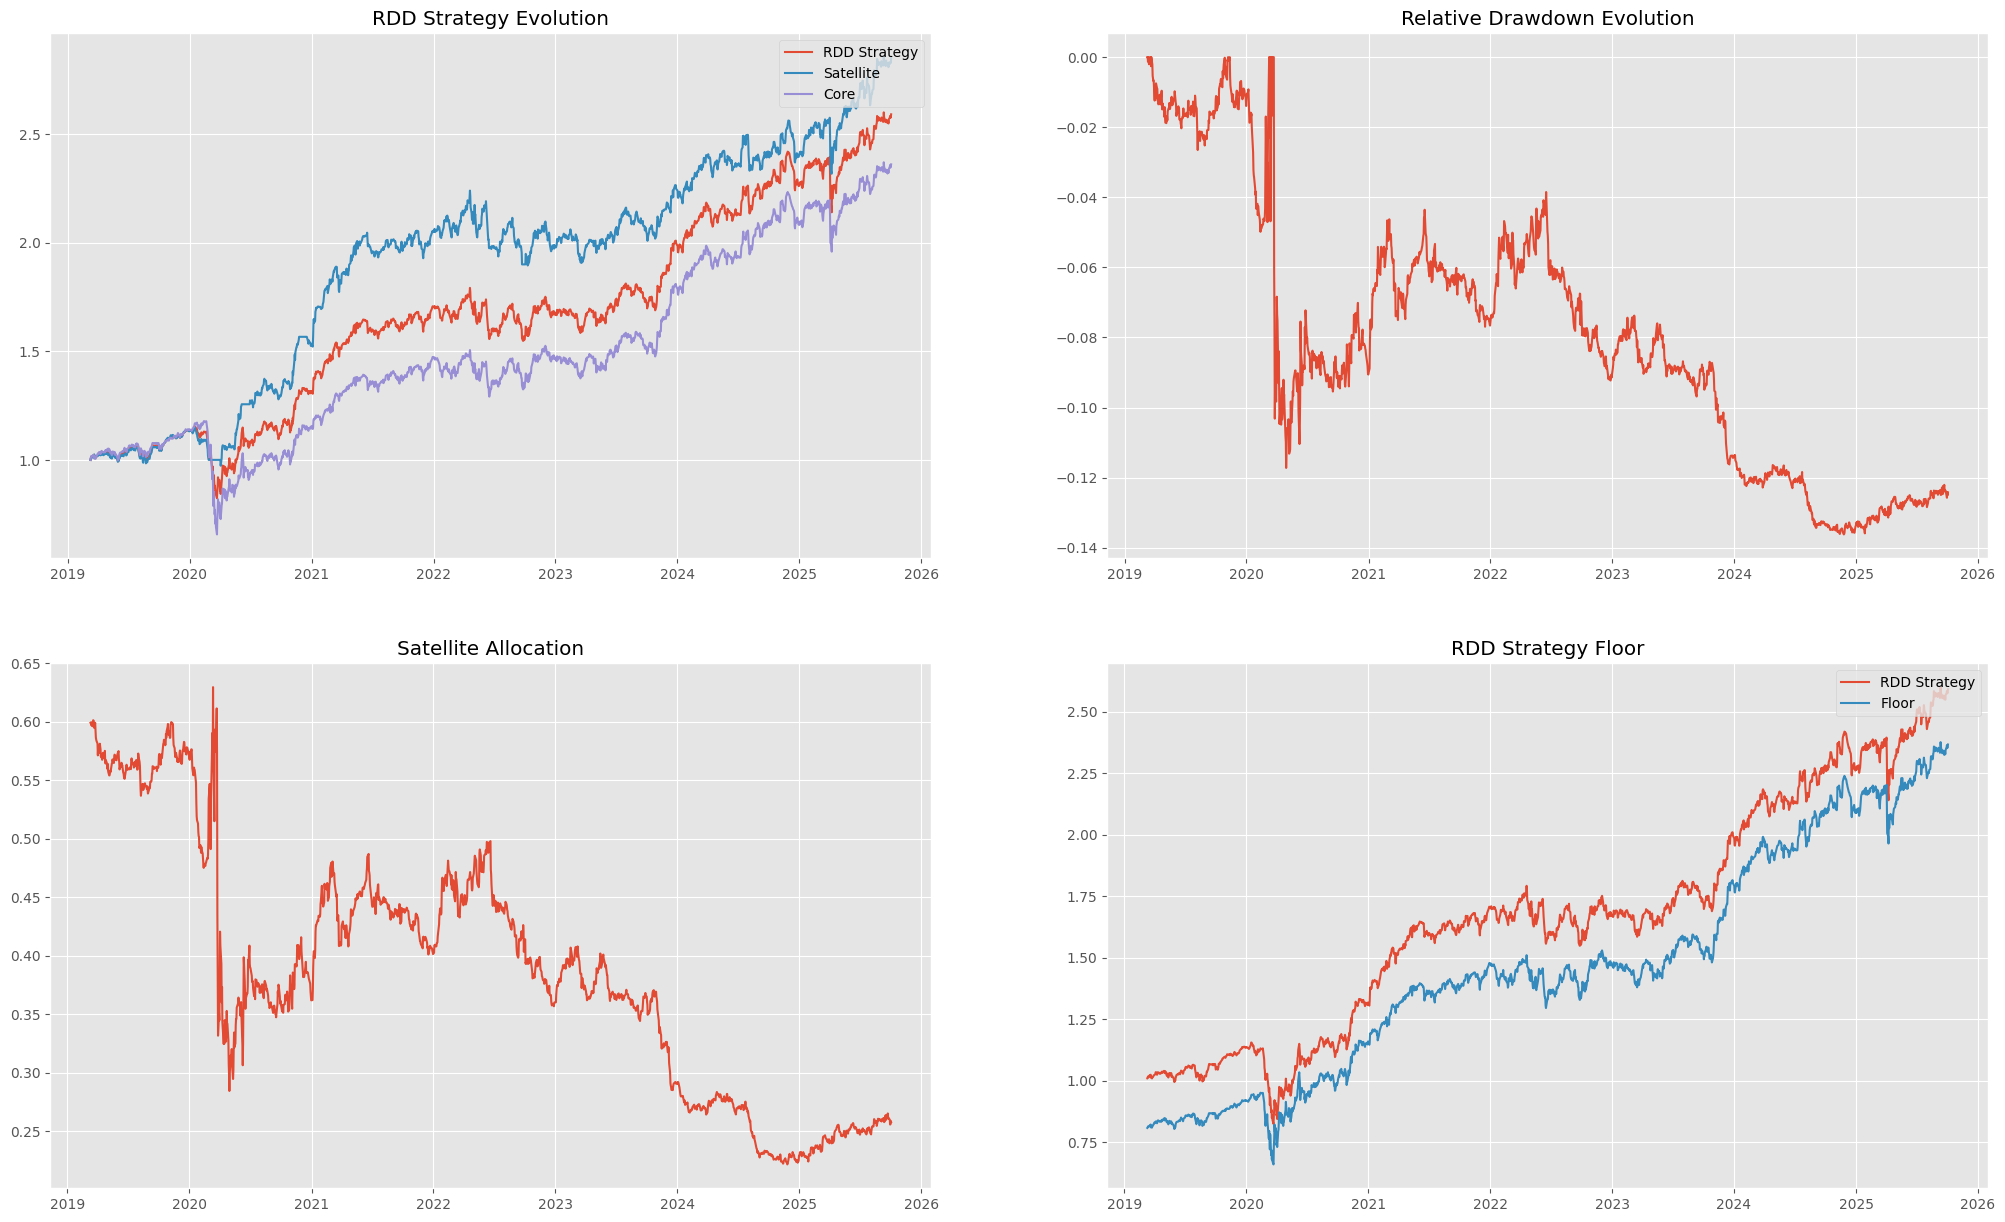

In [6]:
sat_core = False
strategy_type = 'rdd'
strategy_name = strategy_type + '_account'
daa_simulation = DAASimulation(daa, strategy_type, m, kappa, rebal,start_value, window,  sat_core, w_bounds, are_returns, plot)
daa_result = daa_simulation.daa_simulation()  

In [7]:
results = returns.join(daa_result['history'][strategy_name].pct_change().dropna(), on = 'Date')
results = results.join(backtest_results['portfolio_value'].pct_change().dropna(), on = 'Date')
results = results.dropna() # drop first 30 days required for first HRP estimation

In [8]:
metrics = [(annualized_returns, {}), (annualized_volatility, {}),
                   (ratio_metric, {'metric': 'sharpe_ratio', 'target': TARGET}
                    ), (scipy_metric, {'metric': 'skewness'}),
                   (scipy_metric, {'metric': 'kurtosis'}
                    ), (scipy_metric, {'metric': 'normal_test'}),
                   (cf_value_at_risk, {'percentage': PERCENTAGE}),
                   (ratio_metric, {'metric': 'c_f_var_ratio',
                    'target': TARGET, 'percentage': PERCENTAGE}),
                   (max_drawdown, {}), (ratio_metric, {
                       'metric': 'calmar_ratio', 'target': TARGET}),
                   (modified_burke_drawdown_measure, {}), (ratio_metric, {
                       'metric': 'modified_burke_ratio', 'target': TARGET}),
                   (omega_ratio_put_option, {'target': TARGET}),
                   (sortino_ratio, {'target': TARGET})
                   ]

# try metrics=ALL_ABS_METRICS
results_table = performance_metrics(results.drop(columns=['cash_bank']), metrics, round_to=5)

ratio_metric: estimating sharpe_ratio using target of 0.05
cf_value_at_risk: VaR estimated using a confidence level of: 95.0%
ratio_metric: estimating c_f_var_ratio using target of 0.05
cf_value_at_risk: VaR estimated using a confidence level of: 95.0%
using RETURNS...
ratio_metric: estimating calmar_ratio using target of 0.05
using RETURNS...
using RETURNS...
ratio_metric: estimating modified_burke_ratio using target of 0.05
using RETURNS...
computing lower_partial_moments of order: 1
computing lower_partial_moments of order: 2


,annualized_returns,annualized_volatility,sharpe_ratio,skewness,kurtosis,normal_test,cf_value_at_risk,c_f_var_ratio,max_drawdown,calmar_ratio,modified_burke_drawdown_measure,modified_burke_ratio,omega_ratio_put_option,sortino_ratio
AUSF,0.13992,0.20147,0.42515,-0.79744,21.62328,0.0,0.01669,5.13267,0.44246,0.19359,0.07836,1.09303,1.11285,0.00427
LVHI,0.11059,0.15110,0.38194,-1.75529,25.46659,0.0,0.01392,4.14589,0.32310,0.17862,0.07513,0.76817,1.10012,0.00318
MLPA,0.07848,0.31267,0.08673,-2.35026,48.13470,0.0,0.02268,1.19568,0.71529,0.03791,0.19784,0.13706,1.05611,0.00255
SQLV,0.08686,0.25522,0.13754,0.13768,7.07680,0.0,0.02207,1.59024,0.45044,0.07793,0.11679,0.30057,1.05367,0.00254
rdd_account,0.15622,0.15416,0.65633,-0.09525,6.57110,0.0,0.01373,7.36858,0.28677,0.35283,0.05383,1.87959,1.14054,0.00526
cap_floor,0.17317,0.13413,0.87472,0.29180,7.39589,0.0,0.01074,10.92633,0.15391,0.76228,0.05535,2.11957,1.18453,0.00638
